In [2]:
pip install keyboard

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import keyboard
import math
import gym
from sklearn.preprocessing import KBinsDiscretizer
from typing import Tuple

# Configuración inicial sin renderizado
def create_custom_env(length=0.5, mass_cart=1.0, force_mag=10.0, render_mode=None):
    env = gym.make('CartPole-v1', render_mode=render_mode)
    env.env.length = length
    env.env.masscart = mass_cart
    env.env.force_mag = force_mag
    return env

# Crear entorno inicial sin renderizado
env = create_custom_env(render_mode=None)



In [5]:

# Configuración para discretizar estados
n_bins = (4, 6)
lower_bounds = [env.observation_space.low[2], -math.radians(50)]
upper_bounds = [env.observation_space.high[2], math.radians(50)]

def discretizer(_, __, angle, pole_velocity) -> Tuple[int, ...]:
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds])
    return tuple(map(int, est.transform([[angle, pole_velocity]])[0]))

Q_table = np.ones(n_bins + (env.action_space.n,)) * 5

def policy(state: tuple):
    return np.argmax(Q_table[state])

def custom_reward(obs, reward, done):
    x, x_dot, theta, theta_dot = obs
    if done:
        return -200
    if abs(theta) > math.radians(12):
        return -10
    return reward + (1 - abs(theta) / math.radians(12)) * 10 - abs(x) * 0.1

def new_Q_value(reward: float, new_state: tuple, discount_factor=0.95) -> float:
    future_optimal_value = np.max(Q_table[new_state])
    return reward + discount_factor * future_optimal_value

def learning_rate(n: int, min_rate=0.01, max_rate=0.5) -> float:
    return max(min_rate, max_rate / (1 + 0.01 * n))

def exploration_rate(n: int, min_rate=0.1, max_rate=1.0) -> float:
    return max(min_rate, max_rate / (1 + 0.005 * n))


In [6]:

n_episodes = 2000
discount_factor = 0.95
rewards_per_episode = []

for e in range(n_episodes):
    # Cambiar a render_mode="human" a partir del episodio 1000
    if keyboard.is_pressed('q'):
        print("Entrenamiento detenido manualmente.")
        break
    if e == 1000:
        env.close()  # Cerrar el entorno anterior
        env = create_custom_env(render_mode="human")  # Reiniciar con renderizado gráfico

    obs, _ = env.reset()
    current_state, done = discretizer(*obs), False
    total_reward = 0

    while not done:
        if e >= 1000:  # Renderizar solo a partir del episodio 1000
            env.render()

        if np.random.random() < exploration_rate(e):
            action = env.action_space.sample()
        else:
            action = policy(current_state)

        obs, reward, done, _, _ = env.step(action)
        reward = custom_reward(obs, reward, done)
        total_reward += reward
        new_state = discretizer(*obs)

        lr = learning_rate(e)
        learnt_value = new_Q_value(reward, new_state, discount_factor)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1 - lr) * old_value + lr * learnt_value

        current_state = new_state

    rewards_per_episode.append(total_reward)

    if e % 25 == 0:
        print(f"Episode {e}: Total Reward: {total_reward}")

env.close()

C:\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0: Total Reward: -134.0573783386368
Episode 25: Total Reward: 68.22173793041651
Episode 50: Total Reward: 29.957290527221915
Episode 75: Total Reward: -88.59861502553076
Episode 100: Total Reward: -5.641863341692641
Episode 125: Total Reward: -143.90476197539914
Episode 150: Total Reward: -41.58138384127926
Episode 175: Total Reward: 15.61309536451543
Episode 200: Total Reward: 86.28984761855662
Episode 225: Total Reward: 25.362414851768563
Episode 250: Total Reward: 326.1342528243449
Episode 275: Total Reward: 2289.479570787932
Entrenamiento detenido manualmente.


In [10]:
import matplotlib.pyplot as plt

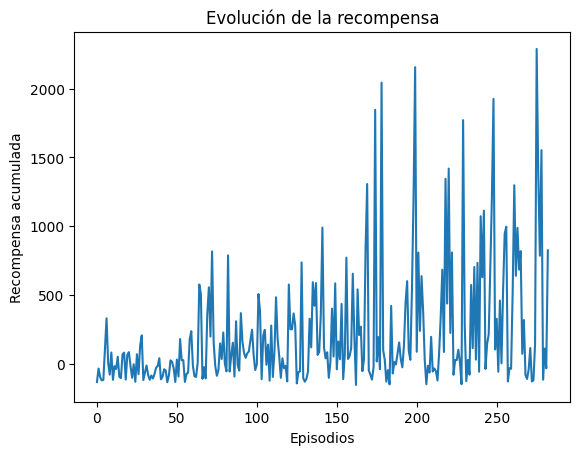

In [11]:
# Graficar evolución de la recompensa acumulada
plt.plot(rewards_per_episode)
plt.xlabel("Episodios")
plt.ylabel("Recompensa acumulada")
plt.title("Evolución de la recompensa")
plt.show()

# Cerrar el entorno al final
env.close()

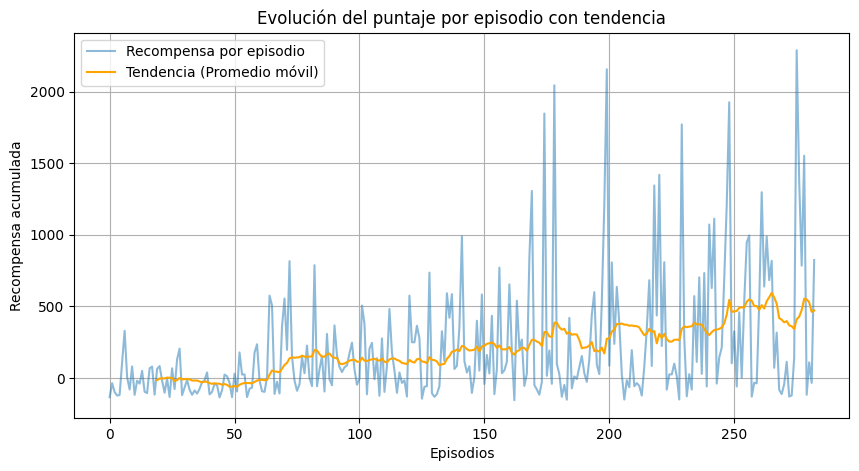

In [12]:
# Calcular el promedio móvil
window_size = 20  # Tamaño de la ventana
moving_avg = np.convolve(rewards_per_episode, np.ones(window_size)/window_size, mode='valid')

# Graficar recompensa acumulada y promedio móvil
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label="Recompensa por episodio", alpha=0.5)
plt.plot(range(window_size - 1, len(rewards_per_episode)), moving_avg, label="Tendencia (Promedio móvil)", color="orange")
plt.xlabel("Episodios")
plt.ylabel("Recompensa acumulada")
plt.title("Evolución del puntaje por episodio con tendencia")
plt.legend()
plt.grid()
plt.show()
